# | HW2(~9/20) | Inception Network 구현

[Inception network](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)는 Inception module 여러개로 구성된 모델이다. 다음 그림을 참고하여 Inception network를 구현하시오.

- **채점 기준**
  - Inception module을 잘 구현해야 한다.
  - 아래의 표에 있는 대로 architecture를 구현해야 한다. (논문과 약간 다르게 auxiliary classifier 등이 생략되어 있다)
  - 아래의 **표에 있는 대로 hyperparameter(filter size, stride, filter 수)를 설정**해야 하고, 각 layer 및 module의 **output size가 표와 같게 나와야 한다.**
  - test accuracy가 **65% 이상** 나와야 한다.
- **제출**
  - "HW2_학번_이름.ipynb" 형태로 저장하여 Jupyter Notebook을 그대로 제출.
    - 예: HW2_2022_12345_keondo.ipynb
  - output 지우지 말아 주세요

## 과제 설명

### Inception Module

- `strides`는 모두 1로 설정해야 output size가 맞게 나올 것이다.



<img src="https://user-images.githubusercontent.com/37704174/108797724-369ef800-75cf-11eb-987a-926657daf61e.JPG" width="400" height="400"/>  



### Inception Network Architecture
- 아래의 표에 있는대로 구성을 하면 이러한 구조의 모델이 만들어진다.

<img src="https://user-images.githubusercontent.com/37704174/108797713-2dae2680-75cf-11eb-8593-5a1bf50549da.png" width="400" height="400"/>  

### Specification


<img src="https://user-images.githubusercontent.com/37704174/109782740-8d9a7200-7c4c-11eb-9999-d859b67dc468.JPG" width="600" height="600"/>  

- 이 표에 있는 대로 위에서부터 layer 및 Inception module을 쌓아야 한다.
- 모든 `Conv2D`와 `MaxPool2D`의 padding 옵션은 `same`으로 설정해야 output size가 올바르게 나올 것이다.
- 표 3행을 보면 convolution의 depth가 2이다. 이것은 `Conv2D` layer가 2개 있다는 뜻이고, 각각의 filter의 수는 64, 192로 설정해야 한다.
- Inception module의 hyperparameter 설명
  - #1x1: 맨 왼쪽 1x1 convolution layer의 filter 수
  - #3x3 reduce: 3x3 convolution layer 이전에 나오는 1x1 convolution layer의 filter 수
  - #3x3: 3x3 convolution layer의 filter 수
  - #5x5 reduce: 5x5 convolution layer 이전에 나오는 1x1 convolution layer의 filter 수
  - #5x5: 5x5 convolution layer의 filter 수
  - pool proj: max pooling 다음에 나오는 1x1 convolution layer의 filter 수

## (Optional) Colab Setup

## Import Modules

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
### 자유롭게 import

## GPU Setting

In [2]:
"""
Make sure your runtime type is GPU!
"""
# tf.test.is_gpu_available(
#     cuda_only=False,
#     min_cuda_compute_capability=None
# )

physical_devices = tf.config.list_physical_devices('GPU')
print('Num_GPUs:{}, List:{}'.format(len(physical_devices), physical_devices))
# print(device_lib.list_local_devices())

Num_GPUs:1, List:[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Implement Inception Network


### Inception Module

In [3]:
from warnings import filters


def InceptionModule(inputs, f_1x1, f_3x3_r, f_3x3, f_5x5_r, f_5x5, f_pool):
    """
    inputs: input of Inception module
    f_ : number of filters in the table above
    
    """
    ### Q1. Make a Inception Module (as Figure 2) ###
    ### Layer1
    layer1 = tf.keras.layers.Conv2D(filters = f_1x1, kernel_size = (1,1), strides=1, padding="same")(inputs)
    ### Layer2
    layer2_red = tf.keras.layers.Conv2D(filters = f_3x3_r, kernel_size=(1,1), strides=1, padding="same")(inputs)
    layer2 = tf.keras.layers.Conv2D(filters = f_3x3, kernel_size=(3,3), strides=1, padding="same")(layer2_red)
    ### Layer 3
    layer3_red = tf.keras.layers.Conv2D(filters = f_5x5_r, kernel_size=(1,1), strides=1, padding="same")(inputs)
    layer3 = tf.keras.layers.Conv2D(filters = f_5x5, kernel_size=(5,5), strides=1, padding="same")(layer3_red)
    ### Layer 4
    layer4_pool = tf.keras.layers.MaxPool2D(strides=1, pool_size = (3,3),padding="same")(inputs)
    layer4 = tf.keras.layers.Conv2D(filters = f_pool, kernel_size=(1,1), strides=1, padding="same")(layer4_pool)

    outputs = tf.keras.layers.concatenate([layer1, layer2, layer3, layer4], axis=-1)
    #######################################
    return outputs

### Inception Network

In [4]:
def InceptionNet():
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))
    
    ### Q2. Make a Inception Network according to the above specification ###
    x = tf.keras.layers.Conv2D(filters = 64, kernel_size=(7,7), strides=1, padding="same")(inputs)
    x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding="same")(x)
    x = tf.keras.layers.Conv2D(filters = 64, kernel_size=(3,3), strides=1, padding="same")(x)
    x = tf.keras.layers.Conv2D(filters = 192, kernel_size=(3,3), strides=1, padding="same")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding="same")(x)

    x = InceptionModule(x, 64, 96, 128, 16, 32, 32)
    x = InceptionModule(x, 64, 96, 128, 16, 32, 32)

    x = InceptionModule(x, 128, 128, 192, 32, 96, 64)
    x = InceptionModule(x, 128, 128, 192, 32, 96, 64)

    x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding="same")(x)

    x = InceptionModule(x, 192, 96, 208, 16, 48, 64)
    x = InceptionModule(x, 192, 96, 208, 16, 48, 64)

    x = InceptionModule(x, 160, 112, 224, 24, 64, 64)
    x = InceptionModule(x, 160, 112, 224, 24, 64, 64)

    x = InceptionModule(x, 128, 128, 256, 24, 64, 64)
    x = InceptionModule(x, 128, 128, 256, 24, 64, 64)

    x = InceptionModule(x, 112, 144, 288, 32, 64, 64)
    x = InceptionModule(x, 112, 144, 288, 32, 64, 64)

    x = InceptionModule(x, 256, 160, 320, 32, 128, 128)
    x = InceptionModule(x, 256, 160, 320, 32, 128, 128)

    x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding="same")(x)

    x = InceptionModule(x, 256, 160, 320, 32, 128, 128)
    x = InceptionModule(x, 256, 160, 320, 32, 128, 128)

    x = InceptionModule(x, 384, 192, 384, 48, 128, 128)
    x = InceptionModule(x, 384, 192, 384, 48, 128, 128)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dense(10, activation="linear")(x)

    x = tf.keras.layers.Dense(10, activation="softmax")(x)
        
    outputs = x
    
    #########################################################################
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [5]:
my_inception = InceptionNet()

### Model Summary

아래 셀을 실행 했을 때, 표의 각각에 해당하는 output size가 맞게 나와야 한다.

In [6]:
my_inception.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   36928       max_pooling2d[0][0]              
______________________________________________________________________________________________

## 2. Dataset

### Training Data

아래의 데이터를 이용한다.

In [16]:
### DO NOT MODIFY ###

#Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

#Split train set into train/valid set
from sklearn import model_selection
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, y_train,test_size=0.1)

### Data Preprocessing

원하는 대로 데이터를 전처리 해주면 된다.

In [17]:
## Q3. Data preprocessing (ex. normalize...) ##
#Data preprocessing/augmentation for training images
import numpy as np
print ("mean before normalization:", np.mean(x_train)) 
print ("std before normalization:", np.std(x_train))

mean=[0,0,0]
std=[0,0,0]
newX_train = np.ones(x_train.shape)
newX_valid = np.ones(x_valid.shape)
newX_test = np.ones(x_test.shape)
#train set에 있는 데이터로만 평균과 표준편차를 구함
for i in range(3):
    mean[i] = np.mean(x_train[:,:,:,i])
    std[i] = np.std(x_train[:,:,:,i])

#train과 test셋 모두 정규화 작업    
for i in range(3):
    newX_train[:,:,:,i] = x_train[:,:,:,i] - mean[i]
    newX_train[:,:,:,i] = newX_train[:,:,:,i] / std[i]
    newX_valid[:,:,:,i] = x_valid[:,:,:,i] - mean[i]
    newX_valid[:,:,:,i] = newX_valid[:,:,:,i] / std[i]
    newX_test[:,:,:,i] = x_test[:,:,:,i] - mean[i]
    newX_test[:,:,:,i] = newX_test[:,:,:,i] / std[i]
        
x_train = newX_train
x_valid = newX_valid
x_test = newX_test

print ("mean after normalization:", np.mean(x_train))
print ("std after normalization:", np.std(x_train))
print(x_train.max())

# ---
# set up image augmentation
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=35,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    )
    
datagen.fit(x_train)
datagen.fit(x_valid)
datagen.fit(x_test)

mean before normalization: 120.64708240740741
std before normalization: 64.12461677909944
mean after normalization: 2.9326335598617096e-17
std after normalization: 0.9999999999999992
2.128755977855811


## 3. Training

### Model Compile

Optimizer, Loss function을 알맞게 설정한다. <br>
Callbacks도 자유롭게 사용한다.

In [20]:
# Learning rate decay function
def decay(epoch):
    ####### 실습 #######
    if epoch < 10:
        return 1e-3
    elif epoch < 30:
        return 1e-4
    else:
        return 1e-5
    ###################
    
import math
def exp_decay(epoch):
    ####### 실습 #######
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * math.exp(0.5 * (10-epoch))
    ###################

In [21]:
## Q4. Model compile ##
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
my_inception.compile(loss=loss_fn, optimizer='adam', metrics=['accuracy'])
#######################

In [22]:
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(exp_decay), 
    tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7)
]

### Model Training

hyperparameter를 적절히 설정한다. (epochs 등..)

In [23]:
## Q5. Set hyperparameters & training ##
hist = my_inception.fit(x=x_train, 
                        y=y_train, 
                        validation_data=(x_valid, y_valid),
                        # your hyperparameters...+
                        
                        batch_size = 64,
                        epochs = 30,
                        callbacks = callbacks
                        )
########################################

Epoch 1/30
704/704 [==============================] - 46s 61ms/step - loss: 1192.6639 - accuracy: 0.2336 - val_loss: 2.3422 - val_accuracy: 0.2880
Epoch 2/30
704/704 [==============================] - 39s 55ms/step - loss: 1.8938 - accuracy: 0.3622 - val_loss: 1.8821 - val_accuracy: 0.3724
Epoch 3/30
704/704 [==============================] - 38s 54ms/step - loss: 1.6638 - accuracy: 0.4234 - val_loss: 1.7366 - val_accuracy: 0.4086
Epoch 4/30
704/704 [==============================] - 39s 55ms/step - loss: 1.5156 - accuracy: 0.4670 - val_loss: 1.5107 - val_accuracy: 0.4674
Epoch 5/30
704/704 [==============================] - 38s 54ms/step - loss: 1.4220 - accuracy: 0.4992 - val_loss: 1.4387 - val_accuracy: 0.5000
Epoch 6/30
704/704 [==============================] - 38s 54ms/step - loss: 1.3557 - accuracy: 0.5197 - val_loss: 1.3320 - val_accuracy: 0.5192
Epoch 7/30
704/704 [==============================] - 39s 56ms/step - loss: 1.2855 - accuracy: 0.5465 - val_loss: 1.3519 - val_accura

## 참고 >

조교가 학습한 모델의 validation accuracy를 그래프로 나타내 보았다.

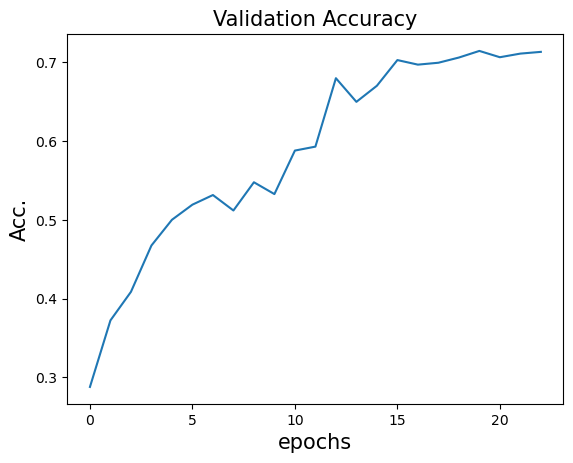

In [24]:
import matplotlib.pyplot as plt

plt.plot(hist.history['val_accuracy'])
plt.title('Validation Accuracy', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('Acc.', fontsize=15)

plt.show()

## Test Accuracy

Test accuracy 측정 결과 **65% 이상**이 나와야 한다.

In [25]:
### DO NOT MODIFY ###
my_inception.evaluate(x_test, y_test)

313/313 [==============================] - 5s 17ms/step - loss: 1.0272 - accuracy: 0.7090


[1.027167558670044, 0.7089999914169312]